# Исследование причин убыточности приложения Procrastinate Pro+

Цель: Разобраться в причинах убыточности развлекательного приложения Procrastinate Pro+, в последние несколько месяцев, несмотря 
    на огромные вложения в рекламу.
    
Входные данные(данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года):
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.  

Необходимо изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

## Оглавление
1 Открываем файлы и изучаем данные  
1.1 Подключаем библиотеки для проведения анализа  
1.2 Загружаем данные  
1.3 Проверяем корректность загруженых данных  
2 Предварительная обработка  
2.1 Проверка на наличие пропусков  
2.2 Поиск дубликатов  
2.2.1 Поиск явных дубликатов в `visits`  
2.2.2 Поиск неявных дубликатов в `visits`  
2.2.3 Поиск явных дубликатов в `orders`  
2.2.4 Поиск неявных дубликатов в `orders`  
2.2.5 Поиск явных дубликатов в `costs`  
2.2.6 Поиск неявных дубликатов в `costs`  
3 Объявление функций  
3.1 Объявление функций для расчета значений метрик  
3.1.1 Функция пользовательских профилей `get_profiles`  
3.1.2 Функция для расчёта удержания `get_retention`  
3.1.3 Функция для расчёта конверсии `get_conversion`  
3.1.4 Функция для расчёта LTV и ROI `get_ltv`  
3.2 Объявление функций для построения графиков  
3.2.1 Функция для сглаживания данных `filter_data`  
3.2.2 Функция для построения графика Retention Rate `plot_retention`  
3.2.3 Функция для построения графика конверсии `plot_conversion`  
3.2.4 Функция для визуализации LTV и ROI `plot_ltv_roi`  
4 Исследовательский анализ данных  
4.1 Составляем профиль пользователей на основе сессий и покупок  
4.2 Определяем минимальную и максимальную даты привлечения пользователей  
4.3 Вычисляем количество и долю платящих пользователей по странам  
4.4 Вычисляем количество и долю платящих пользователей по странам  
4.5 Вычисляем количество и долю платящих пользователей по источникам  
5 Маркетинг  
5.1 Общая сумма расходов на маркетинг  
5.2 Распределение трат по рекламным источникам  
5.3 Расходы по источникам во времени  
5.4 Расчет средней стоимости привлечения пользователей по источникам  
6 Оценка окупаемости рекламы  
6.1 LTV, CAC и ROI  
6.2 Конверсия по каналам  
6.3 Конверсия по устройствам  
6.4 Конверсия по странам  
6.5 Удержание по каналам  
6.6 Удержание по устройствам  
6.7 Удержание по странам  
6.8 LTV, CAC и ROI по устройствам  
6.9 LTV, CAC и ROI по странам  
6.10 LTV, CAC и ROI по рекламным каналам  

6.11 LTV, CAC и ROI по устройствам (без страны `United States`)   

6.12 LTV, CAC и ROI по каналам (без страны `United States`)   

6.13 LTV, CAC и ROI по каналам (только в `United States`)   

6.14 LTV, CAC и ROI по устройствам (только в `United States`)   

7 Выводы

## 1 Открываем файлы и изучаем данные

### 1.1 Подключаем библиотеки для проведения анализа

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

### 1.2 Загружаем данные

In [2]:
# загружаем данные о визитах
visits = pd.read_csv('/datasets/visits_info_short.csv')
# загружаем данные о заказах
orders = pd.read_csv('/datasets/orders_info_short.csv')
# загружаем данные о расходах
costs = pd.read_csv('/datasets/costs_info_short.csv')

### 1.3 Проверяем корректность загруженых данных

#### Таблица `visits`

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Итак мы видим
- В заголовках есть пробелы и заглавные буквы.
- Необходимо привести колонки `Session Start` и `Session End` к типу `datetime`.

##### Исправляем заголовки

In [5]:
# Исправляем заголовки
visits = visits.rename(columns=lambda x: x.replace(' ', '_'))
visits.columns = visits.columns.str.lower()

In [6]:
# Проверяем корректность исправления
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


##### Исправляем некорректный тип данных в столбцах с датой и временем

In [7]:
# Исправляем тип данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_start'])

In [8]:
# Проверяем корректность исправления
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Итак, в таблице `visits` все данные корректные.

#### Таблица `orders`

In [9]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Итак мы видим
- В заголовках есть пробелы и заглавные буквы.
- Необходимо привести колонку `Event Dt` к типу `datetime`.

##### Исправляем заголовки

In [11]:
# Исправляем заголовки
orders = orders.rename(columns=lambda x: x.replace(' ', '_'))
orders.columns = orders.columns.str.lower()

In [12]:
# Проверяем корректность исправления
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


##### Исправляем некорректный тип данных в столбцах с датой и временем

In [13]:
# Исправляем тип данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [14]:
# Проверяем корректность исправления
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Итак, в таблице `orders` все данные корректные.

#### Таблица `costs`

In [15]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [16]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Итак мы видим
- в заголовках есть заглавные буквы;
- необходимо привести колонки `dt` к типу `datetime`

##### Исправляем заголовки

In [17]:
# Исправляем заголовки
costs.columns = costs.columns.str.lower()

In [18]:
# Проверяем корректность исправления
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


##### Исправляем некорректный тип данных в столбцах с датой и временем

In [19]:
# Исправляем тип данных
costs['dt'] = pd.to_datetime(costs['dt'])

In [20]:
# Проверяем корректность исправления
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


Итак, в таблице `costs` все данные корректные.

## 2 Предварительная обработка

### 2.1 Проверка на наличие пропусков

In [21]:
# Считаем долю пропусков по колонкам таблицы `visits`
visits.isna().mean()

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

In [22]:
# Считаем долю пропусков по колонкам таблицы `orders`
orders.isna().mean()

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

In [23]:
# Считаем долю пропусков по колонкам таблицы `costs`
costs.isna().mean()

dt         0.0
channel    0.0
costs      0.0
dtype: float64

Итак, пропущенных значений в данных нет

### 2.2 Поиск дубликатов

#### 2.2.1 Поиск явных дубликатов в `visits`

In [24]:
visits[visits.duplicated()]

,user_id,region,device,channel,session_start,session_end


In [25]:
visits[visits.duplicated(['region', 'device', 'channel', 'session_start', 'session_end'])]

,user_id,region,device,channel,session_start,session_end
1921,69009997544,United States,iPhone,organic,2019-05-03 17:31:15,2019-05-03 17:31:15
1937,221471070307,United States,iPhone,organic,2019-05-03 18:35:51,2019-05-03 18:35:51
5338,996440777277,United States,Android,TipTop,2019-05-07 21:24:51,2019-05-07 21:24:51
8833,543787195203,United States,iPhone,organic,2019-05-11 18:00:29,2019-05-11 18:00:29
9669,315545423679,United States,iPhone,organic,2019-05-11 21:13:38,2019-05-11 21:13:38
...,...,...,...,...,...,...
207273,545290122477,United States,iPhone,TipTop,2019-10-31 09:08:21,2019-10-31 09:08:21
222000,102205122364,UK,PC,organic,2019-05-30 10:18:02,2019-05-30 10:18:02
225646,846285941991,UK,PC,LeapBob,2019-06-06 07:50:47,2019-06-06 07:50:47
242598,399735084663,France,PC,organic,2019-07-09 09:11:53,2019-07-09 09:11:53


Итак, в `visits` нет явных дубликатов

#### 2.2.2 Поиск неявных дубликатов в `visits`

Неявные дубликаты будем искать через подсчет уникальных значений

In [26]:
visits['region'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

In [27]:
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

In [28]:
visits['channel'].value_counts()

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

Итак, неявных дубликатов в `visits` нет

#### 2.2.3 Поиск явных дубликатов в `orders`

In [29]:
orders[orders.duplicated()]

,user_id,event_dt,revenue


In [30]:
orders[orders.duplicated(['event_dt', 'revenue'])]

,user_id,event_dt,revenue
1824,170668637792,2019-05-29 19:01:17,4.99
2896,223185762154,2019-06-08 00:59:57,4.99
5114,856419621025,2019-06-27 06:09:53,4.99
7303,964224732612,2019-07-11 16:23:26,4.99
12162,692882859884,2019-08-12 22:50:49,4.99
13373,185994924211,2019-08-19 22:11:15,4.99
14674,716459216776,2019-08-27 01:54:34,4.99
15584,796274288389,2019-09-01 00:17:01,4.99
16989,841629834145,2019-09-09 20:01:39,4.99
19983,735997033255,2019-09-24 03:34:47,4.99


In [31]:
orders.duplicated(['event_dt', 'revenue']).mean()

0.0011439371331940715

Итак, мы имеем 0,11% явных дубликатов в заказах, у которых одинаковое время и сумма заказа. Эти дубликаты мы можем удалить, так как их количество незначительно

In [32]:
orders = orders.drop_duplicates(subset=['event_dt', 'revenue'], keep='first')

Проверяем что дубликаты удалены

In [33]:
orders.duplicated(['event_dt', 'revenue']).mean()

0.0

Проверяем что таблица не испортилась

In [34]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40166 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40166 non-null  int64         
 1   event_dt  40166 non-null  datetime64[ns]
 2   revenue   40166 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


Итак, явные дубликаты в `orders` устранены

#### 2.2.4 Поиск неявных дубликатов в `orders`

In [35]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Неявных дубликатов в `orders` нет, так как у нас нет категориальных переменных.

#### 2.2.5 Поиск явных дубликатов в `costs`

In [36]:
costs[costs.duplicated()]

,dt,channel,costs


Итак, явных дубликатов в `costs` нет

#### 2.2.6 Поиск неявных дубликатов в `costs`

In [37]:
costs['channel'].value_counts()

LeapBob               180
FaceBoom              180
OppleCreativeMedia    180
AdNonSense            180
YRabbit               180
TipTop                180
RocketSuperAds        180
MediaTornado          180
lambdaMediaAds        180
WahooNetBanner        180
Name: channel, dtype: int64

Неявных дубликатов в costs нет.

Итак мы:
- скорректировали названия столбцов в таблицах `visits`, `orders` и `costs`;
- исправили некорректный формат столбцов с датой в таблицах `visits`, `orders` и `costs`;
- устранили `0,11%` явных дубликатов в таблице `orders`. 

Других проблем не выявлено.

### 3 Объявление функций

### 3.1 Объявление функций для расчета значений метрик

#### 3.1.1 Функция пользовательских профилей `get_profiles`

In [38]:
# функция для расчёта пользовательских профилей 
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs['dt'] = ad_costs['dt'].dt.date
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### 3.1.2 Функция для расчёта удержания `get_retention`

In [39]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### 3.1.3 Функция для расчёта конверсии `get_conversion`

In [40]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


#### 3.1.4 Функция для расчёта LTV и ROI `get_ltv`

In [41]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


### 3.2 Объявление функций для построения графиков

#### 3.2.1 Функция для сглаживания данных `filter_data`

In [42]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### 3.2.2 Функция для построения графика Retention Rate `plot_retention`

In [43]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()


#### 3.2.3 Функция для построения графика конверсии `plot_conversion`

In [44]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### 3.2.4 Функция для визуализации LTV и ROI `plot_ltv_roi`

In [45]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### 4 Исследовательский анализ данных

#### 4.1 Составляем профиль пользователей на основе сессий и покупок

In [46]:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


Проверяем что не появилось дублей пользователей, то есть не получилось, что `user_id` имел разные страны, телефоны или канал привлечения.

In [47]:
profiles['user_id'].value_counts()

784601515991    1
761110562921    1
685821223803    1
252457996991    1
871256332998    1
               ..
80423523736     1
731539533255    1
43790755222     1
381232125368    1
927413009711    1
Name: user_id, Length: 150008, dtype: int64

Итак, дублей не появлось. Все в порядке.

#### 4.2 Определяем минимальную и максимальную даты привлечения пользователей

In [48]:
min_analysis_date = pd.to_datetime(profiles['dt']).min().date()
observation_date =  pd.to_datetime(profiles['dt']).max().date()

In [49]:
print(f'Минимальная дата привлечения: {min_analysis_date}')
print(f'Максимальная дата привлечения: {observation_date}')

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


#### 4.3 Вычисляем количество и долю платящих пользователей по странам

In [50]:
t = profiles.pivot_table(index='region', aggfunc={'user_id':'count', 'payer':'mean'}) \
            .sort_values(by='user_id', ascending = False)
t.columns = ['Доля платящих пользователей', 'Количество пользователей']
t['Количество платящих пользователей'] = t['Доля платящих пользователей']*t['Количество пользователей']
t['Доля платящих пользователей'] = t['Доля платящих пользователей'].round(decimals = 3)
t['Количество платящих пользователей'] = t['Количество платящих пользователей'].astype(int)
t

,Доля платящих пользователей,Количество пользователей,Количество платящих пользователей
region,,,
United States,0.069,100002,6900
UK,0.040,17575,700
France,0.038,17450,663
Germany,0.041,14981,616


По сводной таблице можно сделать выводы:
- Больше всего пользователей приходят из `United States`.
- Новые пользователи приходят из `United States`, `Germany`, `UK`, `France`.
- Больше всего пользователей и самая большая доля платящих в `United States`.

#### 4.4 Вычисляем количество и долю платящих пользователей по странам

In [51]:
t = profiles.pivot_table(index='device', aggfunc={'user_id':'count', 'payer':'mean'}) \
            .sort_values(by='user_id', ascending = False)
t.columns = ['Доля платящих пользователей', 'Количество пользователей']
t['Количество платящих пользователей'] = t['Доля платящих пользователей']*t['Количество пользователей']
t['Доля платящих пользователей'] = t['Доля платящих пользователей'].round(decimals = 3)
t['Количество платящих пользователей'] = t['Количество платящих пользователей'].astype(int)
t

,Доля платящих пользователей,Количество пользователей,Количество платящих пользователей
device,,,
iPhone,0.062,54479,3380
Android,0.059,35032,2050
PC,0.050,30455,1537
Mac,0.064,30042,1912


По сводной таблице можно сделать выводы:
- Клиенты пользуются `iPhone`, `Android`, `PC` и `Mac`.
- Чаще всего как платящие, так и неплатящие пользователи пользуются `iPhone`.
- Чаще пользователи работают с мобильных устройств `iPhone`, `Android` и реже со стационарных.

#### 4.5 Вычисляем количество и долю платящих пользователей по источникам

In [52]:

t = profiles.pivot_table(index='channel', aggfunc={'user_id':'count', 'payer':'mean'}) \
            .sort_values(by='user_id', ascending = False)

t.columns = ['Доля платящих пользователей в канале', 'Количество пользователей']

# Вычисляем общее количество пользователей
total_users = t['Количество пользователей'].sum()

t['Количество платящих пользователей'] = (t['Доля платящих пользователей в канале']*t['Количество пользователей'])
# Добавляем колонку с долей пользователей по каждому источнику
t['Доля пользователей'] = (t['Количество пользователей'] / total_users)

# Вычисляем общее количество платящих пользователей
total_pay_users = t['Количество платящих пользователей'].sum()
# Добавляем колонку с долей платящих пользователей по каждому источнику
t['Доля платящих пользователей'] = (t['Количество платящих пользователей'] / total_pay_users)

# Округляем дробные значения
t['Доля платящих пользователей в канале'] = t['Доля платящих пользователей в канале'].map('{:,.2f}'.format)
t['Доля пользователей'] = t['Доля пользователей'].map('{:,.2f}'.format)
t['Доля платящих пользователей'] = t['Доля платящих пользователей'].map('{:,.2f}'.format)
t['Количество платящих пользователей'] = t['Количество платящих пользователей'].astype(int)
t

,Доля платящих пользователей в канале,Количество пользователей,Количество платящих пользователей,Доля пользователей,Доля платящих пользователей
channel,,,,,
organic,0.02,56439,1160,0.38,0.13
FaceBoom,0.12,29144,3555,0.19,0.40
TipTop,0.10,19561,1878,0.13,0.21
OppleCreativeMedia,0.03,8605,233,0.06,0.03
LeapBob,0.03,8553,262,0.06,0.03
WahooNetBanner,0.05,8553,453,0.06,0.05
RocketSuperAds,0.08,4448,352,0.03,0.04
MediaTornado,0.04,4364,156,0.03,0.02
YRabbit,0.04,4312,165,0.03,0.02


По сводной таблице можно сделать выводы:
- Больше всего **платящих** пользователей пришло из `FaceBoom` **40%** и у него же наибольший процент платящих пользователей внутри канала **12%**.
- ТОП3 каналов привлечения **всех** пользователей: `organic`, `FaceBoom`, `TipTop`.
- ТОП3 каналов привлечения **платящих** пользователей: `FaceBoom`, `TipTop`, `organic`.

### 5 Маркетинг

#### 5.1 Общая сумма расходов на маркетинг

In [53]:
costs['costs'].sum()

105497.30000000002

Общая сумма расходов на рекламу составила **105497**.

#### 5.2 Распределение трат по рекламным источникам

In [54]:
# Вычисляем суммарные расходы по источникм
t = costs.groupby('channel').sum().sort_values(by='costs', ascending=False)
# Вычисляем общую сумму расходов
total_costs = t['costs'].sum()
# Добавляем столбец с долей расходов по источникам
t['costs_percent'] = t['costs'] / total_costs
t

,costs,costs_percent
channel,,
TipTop,54751.30,0.518983
FaceBoom,32445.60,0.307549
WahooNetBanner,5151.00,0.048826
AdNonSense,3911.25,0.037074
OppleCreativeMedia,2151.25,0.020392
RocketSuperAds,1833.00,0.017375
LeapBob,1797.60,0.017039
lambdaMediaAds,1557.60,0.014764
MediaTornado,954.48,0.009047


Более **80%** трат приходится на `TipTop` и `FaceBoom`, а на `TipTop` прходится более **50%**

#### 5.3 Расходы по источникам во времени

Добавляем колонки с датой начала недели и месяца и строим таблицы с расходами по неделям и месяцам 

In [55]:
# сохраняем данные о расходах в отдельную таблицу
costs_w_m = costs.copy()
# меняем формат колонки с датами
costs_w_m['dt'] = pd.to_datetime(costs['dt'])
#Добавляем даты начала недели
costs_w_m['week'] = costs_w_m['dt'].dt.to_period('W').apply(lambda r: r.start_time)
#Добавляем даты начала месяца
costs_w_m['month'] = costs_w_m['dt'].dt.to_period('M').apply(lambda r: r.start_time)

In [56]:
# Строим сводную таблицу для построения графика с раходами по неделям
costs_w = costs_w_m.pivot_table(index=['channel'], columns='week', values='costs', aggfunc='sum')
costs_w

week,2019-04-29,2019-05-06,2019-05-13,2019-05-20,2019-05-27,2019-06-03,2019-06-10,2019-06-17,2019-06-24,2019-07-01,...,2019-08-19,2019-08-26,2019-09-02,2019-09-09,2019-09-16,2019-09-23,2019-09-30,2019-10-07,2019-10-14,2019-10-21
channel,,,,,,,,,,,,,,,,,,,,,
AdNonSense,211.05,273.00,265.65,266.70,202.650,102.90,96.60,141.75,148.05,130.200,...,142.80,133.35,100.800,100.80,139.650,192.15,155.40,136.500,118.650,154.35
FaceBoom,535.70,750.20,755.70,722.70,1208.900,1081.30,1042.80,1280.40,1647.80,1536.700,...,1411.30,1445.40,1151.700,1148.40,1496.000,1837.00,1761.10,1392.600,1291.400,1552.10
LeapBob,16.80,31.71,26.67,26.67,65.520,66.99,52.29,68.46,99.75,87.360,...,90.51,77.91,66.990,63.84,81.270,101.22,101.01,78.960,69.720,84.42
MediaTornado,38.64,61.68,59.04,50.16,36.960,27.60,29.76,32.16,40.56,43.440,...,35.28,33.84,30.240,25.92,30.240,48.24,42.00,36.960,29.040,37.44
OppleCreativeMedia,24.00,34.50,27.50,34.25,81.750,79.50,71.50,79.75,107.00,102.500,...,103.75,92.75,72.750,78.00,105.750,132.25,123.00,88.250,88.000,101.50
RocketSuperAds,99.45,139.23,138.06,131.04,97.695,76.05,63.18,80.73,78.26,75.075,...,40.30,51.35,40.625,40.95,56.225,63.70,66.30,51.675,46.475,50.70
TipTop,347.00,470.00,454.00,801.80,1421.200,1223.60,1121.00,1474.40,2343.60,2340.000,...,2514.00,2583.00,2563.000,2506.00,3241.000,3979.50,3703.00,3097.500,2737.000,3265.50
WahooNetBanner,49.20,92.40,90.00,79.20,179.400,196.80,166.20,201.60,285.00,256.800,...,244.80,235.80,174.600,192.60,226.200,303.00,309.00,208.800,216.000,253.20
YRabbit,52.20,75.90,69.30,65.40,49.800,25.80,17.46,22.14,27.90,28.260,...,30.03,24.36,27.930,29.76,39.600,47.52,45.36,38.310,36.450,48.33


In [57]:
# Строим сводную таблицу для построения графика с раходами по месяцам
costs_m = costs_w_m.pivot_table(index=['channel'], columns='month', values='costs', aggfunc='sum')
costs_m

month,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01
channel,,,,,,
AdNonSense,1169.70,538.650,504.00,579.60,581.70,537.600
FaceBoom,3524.40,5501.100,5294.30,6274.40,6114.90,5736.500
LeapBob,140.28,314.580,313.53,369.81,343.98,315.420
MediaTornado,238.56,138.000,138.48,154.56,144.72,140.160
OppleCreativeMedia,169.75,370.000,366.50,439.25,427.75,378.000
RocketSuperAds,577.98,325.715,252.07,253.11,218.40,205.725
TipTop,2981.00,6675.600,8410.20,11202.00,13232.50,12250.000
WahooNetBanner,418.80,921.000,851.40,1040.40,977.40,942.000
YRabbit,299.70,106.200,97.38,124.74,152.79,163.410


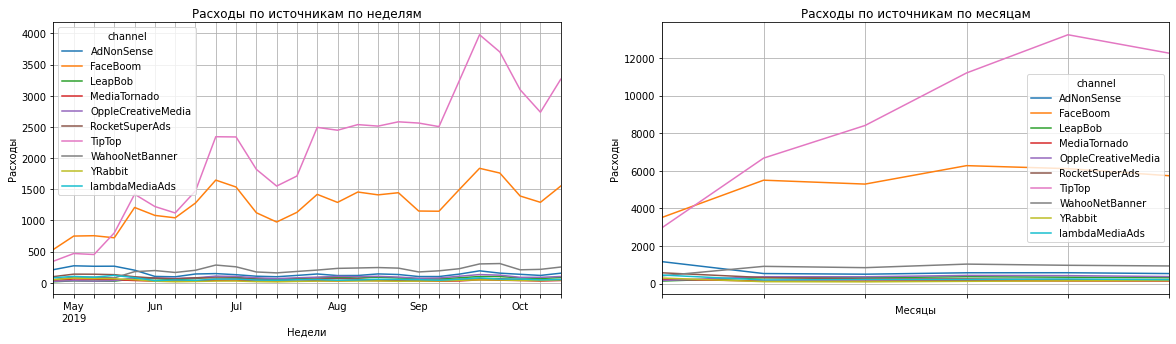

In [58]:
# задаём размер графиков
plt.figure(figsize = (20, 5)) 

# Строим график расходов по неделям и добавляем его в первую ячейку
costs_w.T.plot(
    grid=True, xticks=list(costs_w.columns.values), xlabel='Недели', ylabel='Расходы', ax=plt.subplot(1, 2, 1)
)  
plt.title('Расходы по источникам по неделям')

# Строим график расходов по месяцам и добавляем его во вторую ячейку
costs_m.T.plot(
    grid=True, xticks=list(costs_m.columns.values), xlabel='Месяцы', ylabel='Расходы', ax=plt.subplot(1, 2, 2)
) 
plt.title('Расходы по источникам по месяцам')

#Выводим графики
plt.show()

По графикам можно сделать выводы:  
- Самые большие расходы на рекламу по источникам `TipTop` и `FaceBoom`.  
- Начиная с июня расходы на привлечение пользоватей через `TipTop`, `FaceBoom` и `WahooNetBanner` выросли. 
- По источнику `TipTop` расходы на привлечение пользоватей увеличиваются с каждым месяцем.  

#### 5.4 Расчет средней стоимости привлечения пользователей по источникам

In [59]:
# Рассчитываем количество пользователей по источникам
user_per_channel = profiles.pivot_table(index='channel', values='user_id', aggfunc='count')
user_per_channel.columns = ['Количество пользователей']
user_per_channel.sort_values(by='Количество пользователей', ascending=False)

,Количество пользователей
channel,
organic,56439
FaceBoom,29144
TipTop,19561
OppleCreativeMedia,8605
LeapBob,8553
WahooNetBanner,8553
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


In [60]:
# Рассчитываем расходы по источникам
costs_per_channel = costs.pivot_table(index='channel', values='costs', aggfunc='sum')
costs_per_channel.columns = ['Расходы']
costs_per_channel.sort_values(by='Расходы', ascending=False)

,Расходы
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [61]:
# Объединяем сводные таблицы по расходам и пользователям
avg_user_cost_per_channel = costs_per_channel.merge(user_per_channel, on='channel')

# Добавляем колонку с долей расходов по каждому источнику
total_costs = avg_user_cost_per_channel['Расходы'].sum()
avg_user_cost_per_channel['Доля расходов'] = avg_user_cost_per_channel['Расходы'] / total_costs

# Добавляем колонку с долей пользователей по каждому источнику
total_users = avg_user_cost_per_channel['Количество пользователей'].sum()
avg_user_cost_per_channel['Доля пользователей'] = avg_user_cost_per_channel['Количество пользователей'] / total_costs

# Добавляем колонку со стоимостью привлечения пользователей по каждому источнику
avg_user_cost_per_channel['Стоимость привлечения пользователя'] = avg_user_cost_per_channel['Расходы']/avg_user_cost_per_channel['Количество пользователей']

# Округляем дробные значения
avg_user_cost_per_channel['Доля расходов'] = avg_user_cost_per_channel['Доля расходов'].map('{:,.2f}'.format)
avg_user_cost_per_channel['Доля пользователей'] = avg_user_cost_per_channel['Доля пользователей'].map('{:,.2f}'.format)
avg_user_cost_per_channel['Стоимость привлечения пользователя'] = avg_user_cost_per_channel['Стоимость привлечения пользователя'] \
                                                                    .map('{:,.2f}'.format)

avg_user_cost_per_channel.sort_values(by='Стоимость привлечения пользователя', ascending=False)

,Расходы,Количество пользователей,Доля расходов,Доля пользователей,Стоимость привлечения пользователя
channel,,,,,
TipTop,54751.30,19561,0.52,0.19,2.80
FaceBoom,32445.60,29144,0.31,0.28,1.11
AdNonSense,3911.25,3880,0.04,0.04,1.01
lambdaMediaAds,1557.60,2149,0.01,0.02,0.72
WahooNetBanner,5151.00,8553,0.05,0.08,0.60
RocketSuperAds,1833.00,4448,0.02,0.04,0.41
OppleCreativeMedia,2151.25,8605,0.02,0.08,0.25
MediaTornado,954.48,4364,0.01,0.04,0.22
YRabbit,944.22,4312,0.01,0.04,0.22


По сводной таблице можно сделать выводы:
- Самый дорогой источник по привлечению пользователей это `TipTop`.
- Стоимость привлечения пользвателей через `TipTop` более чем в 2 раза выше чем в канале `FaceBoom`, где привлекли больше всего пользователей.

Итак:
- Всего на привлечение пользователей было потрачено **105497**.
- Больше **80%** расходов приходится на два канала `TipTop` и `FaceBoom`, а на `TipTop` прходится более **50%**.
- Каналы `TipTop` и `FaceBoom` привлекли **45%** всех пользователей.
- Самая высокая стоимость привлечения в канале `TipTop`.  
- Стоимость привлечения через TipTop более чем в **2 раза выше** чем в канале FaceBoom, где привлекли больше всего пользователей.

### 6 Оценка окупаемости рекламы

#### 6.1 LTV, CAC и ROI

Оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV, CAC и ROI

Для начала исключим пользователей `organic`, так как мы на них не влияем.

In [62]:
profiles_n_o = profiles.query('channel!="organic"')
profiles_n_o

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
...,...,...,...,...,...,...,...,...,...
149999,999942424543,2019-05-24 21:03:26,TipTop,iPhone,United States,2019-05-24,2019-05-01,False,1.900000
150001,999949280903,2019-08-12 06:47:27,FaceBoom,Mac,United States,2019-08-12,2019-08-01,False,1.117838
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000


In [63]:
# Определяем момент анализа
observation_date =  pd.to_datetime(profiles['dt']).max().date()
# Задаем горизонт анализа
analysis_horizon = 14

In [64]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_n_o, orders, observation_date, analysis_horizon
)

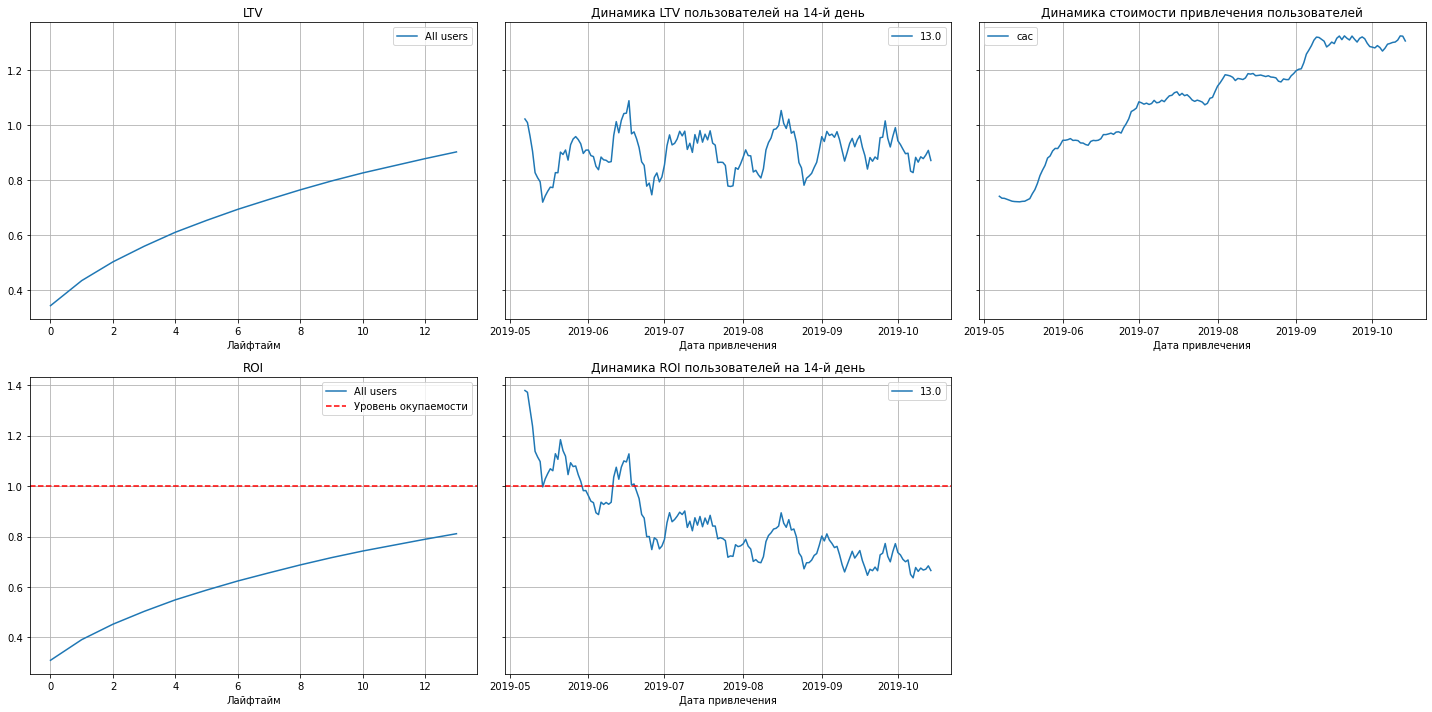

In [65]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

По общим графикам `LTV`, `CAC` и `ROI` можно сделать такие выводы:
- Реклама не окупается. ROI на 14-й день не достигает 100%.
- CAC в июне резко вырос. То есть мы имеем резкий рост рекламного бюджета.
- Значительного изменения LTV(на 14-й день) в июне(одновременно с ростом CAC) нет.
- На графике ROI(на 14-й день) видно, что июньский рост CAC привел к значительному сниженю возврата инвестиций. 

#### 6.2 Конверсия по каналам

Рассчитаем и визуализируем 

In [66]:
# Рассчитываем конверсию с разбивкой по каналам привлечения
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_n_o, orders, observation_date, analysis_horizon, dimensions=['channel']
)

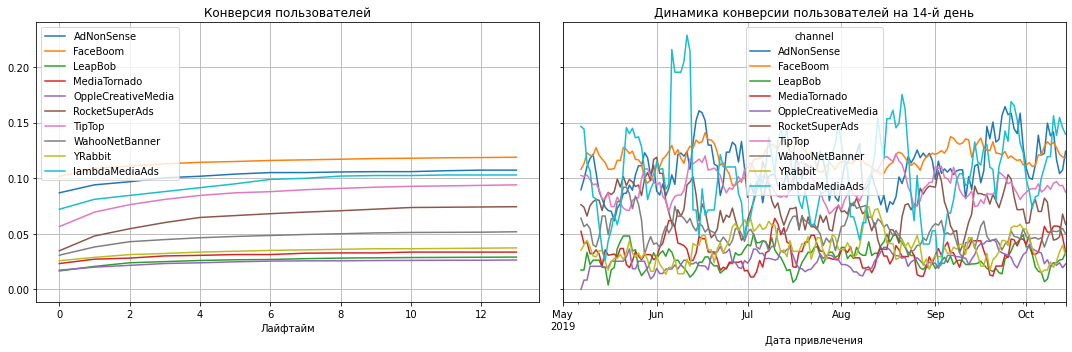

In [67]:
# Строим графики конверсии
plot_conversion(conversion, conversion_history, analysis_horizon, window=7)

По графикам конверсии с разбивкой по каналам привлечения можно сделать выводы:   
- Конверсия основных источников привлечения `TipTop` и `FaceBoom` входит в **ТОП-4** среди всех источников. Еще в **ТОП-4** входят  `lambdaMediaAds` и `AdNonSense`.  
- Динамика конверсии всех источников изменяется вокруг средних значений и стабильна в течении всего времени.

#### 6.3 Конверсия по устройствам

Рассчитаем и визуализируем 

In [68]:
# Рассчитываем конверсию с разбивкой по устройствам
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_n_o, orders, observation_date, analysis_horizon, dimensions=['device']
)

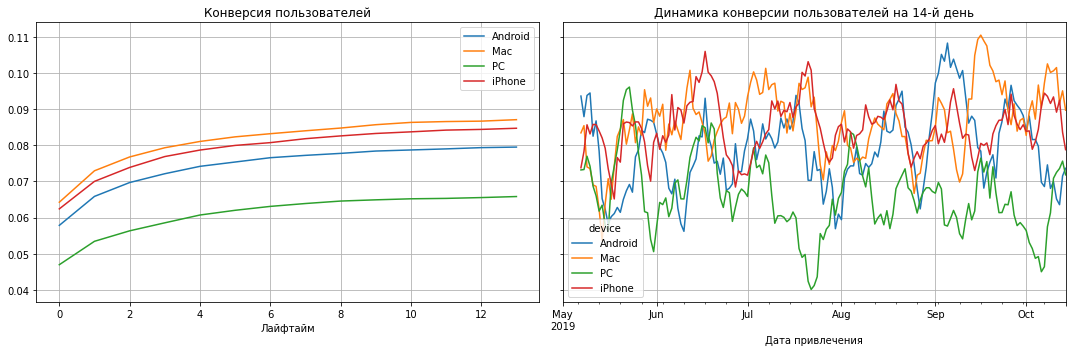

In [69]:
# Строим графики конверсии
plot_conversion(conversion, conversion_history, analysis_horizon, window=7)

По графикам конверсии с разбивкой по устройствам можно сделать выводы:   
- Наибольшая конверсия у `Mac`.  
- Наименьшая конверсия у `PC`.
- Динамика конверсии всех источников изменяется вокруг средних значений и стабильна в течении всего времени.

#### 6.4 Конверсия по странам

Рассчитаем и визуализируем 

In [70]:
# Рассчитываем конверсию с разбивкой по странам
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_n_o, orders, observation_date, analysis_horizon, dimensions=['region']
)

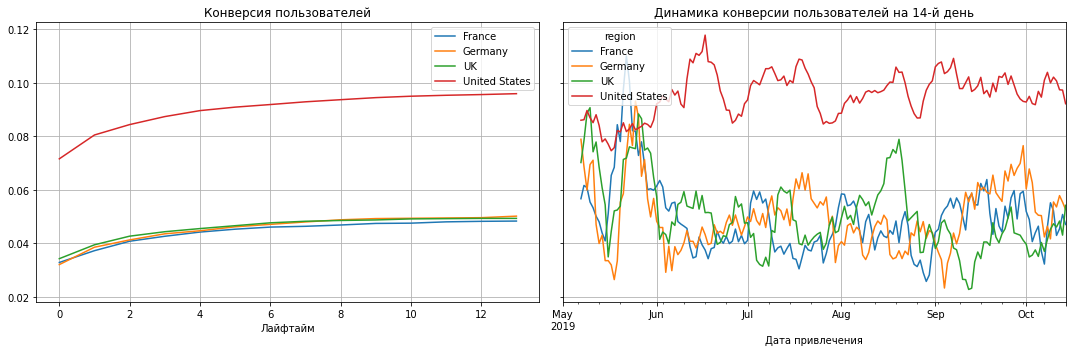

In [71]:
# Строим графики конверсии
plot_conversion(conversion, conversion_history, analysis_horizon, window=7)

По графикам конверсии с разбивкой по странам можно сделать выводы:   
- Наибольшая конверсия у `United States`, а остальные страны имеют схожую конверсию.  
- Динамика конверсии всех источников изменяется вокруг средних значений и стабильна в течении всего времени.

#### 6.5 Удержание по каналам

In [72]:
# Рассчитываем удержание с разбивкой по каналам привлечения
retentio_raw, retention, retention_history = get_retention(
    profiles_n_o, visits, observation_date, analysis_horizon, dimensions=['channel']
)

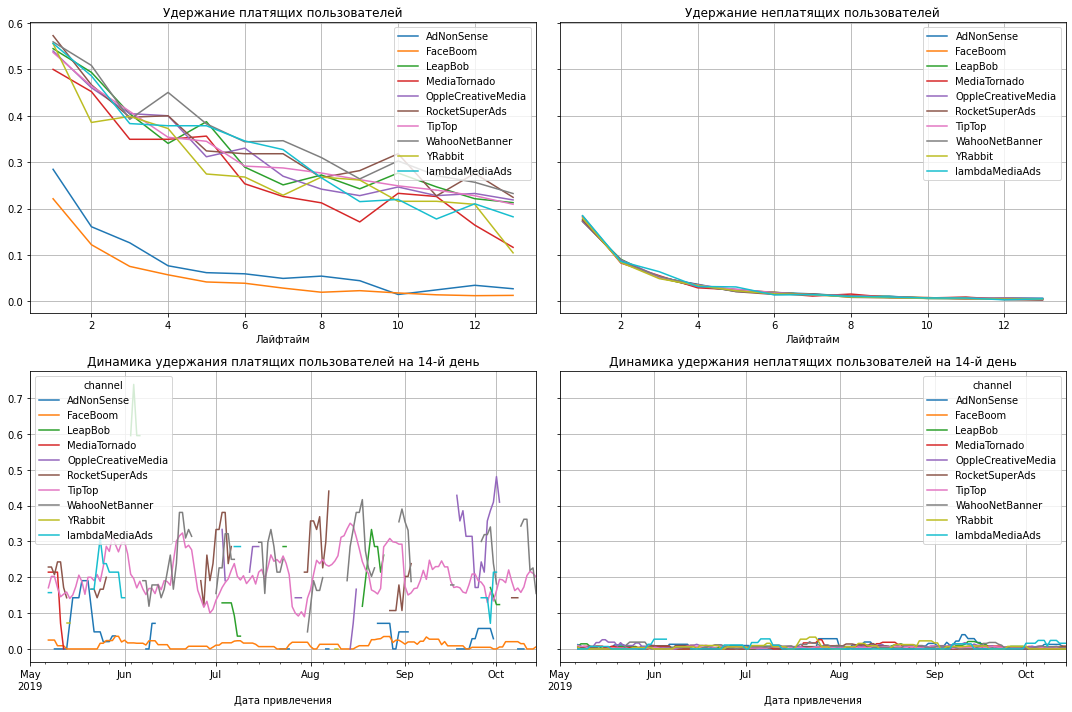

In [73]:
# Строим графики удержания
plot_retention(retention, retention_history, analysis_horizon, window=7)

По графикам удержания с разбивкой по канала привлечения можно сделать выводы:  
- Удержание платящих пользователей пришедших из `FaceBoom` и `AdNonSense` примерно в 3-4 раза ниже чем в остальных источниках.  
- Все источники, кроме `FaceBoom` и `AdNonSense`, имеют схожие значения удержания, лучше всех выглядят `lambdaMediaAds`, `WahooNetBanner` и `RockeSuperAds`.  
- Динамика удержания среди источников `TipTop`, `RocketSuperAds` стабильна в течении всего времени.    
- По источникам `AdNonSense` `LeapBob`, `MediaTornado`, `OppleCreativeMedia`, `WahooNetBanner`, `YRabbit`, `lambdaMediaAds` количество платящих пользователей минимально и при недельном сглаживании графики удержания выглядят прерывисто.  
- Удержание и динамика удержания неплатящих пользователей имеют меньшие значения по сравнению с платящими, что нормально.

#### 6.6 Удержание по устройствам

In [74]:
# Рассчитываем удержание с разбивкой по устройствам
retentio_raw, retention, retention_history = get_retention(
    profiles_n_o, visits, observation_date, analysis_horizon, dimensions=['device']
)

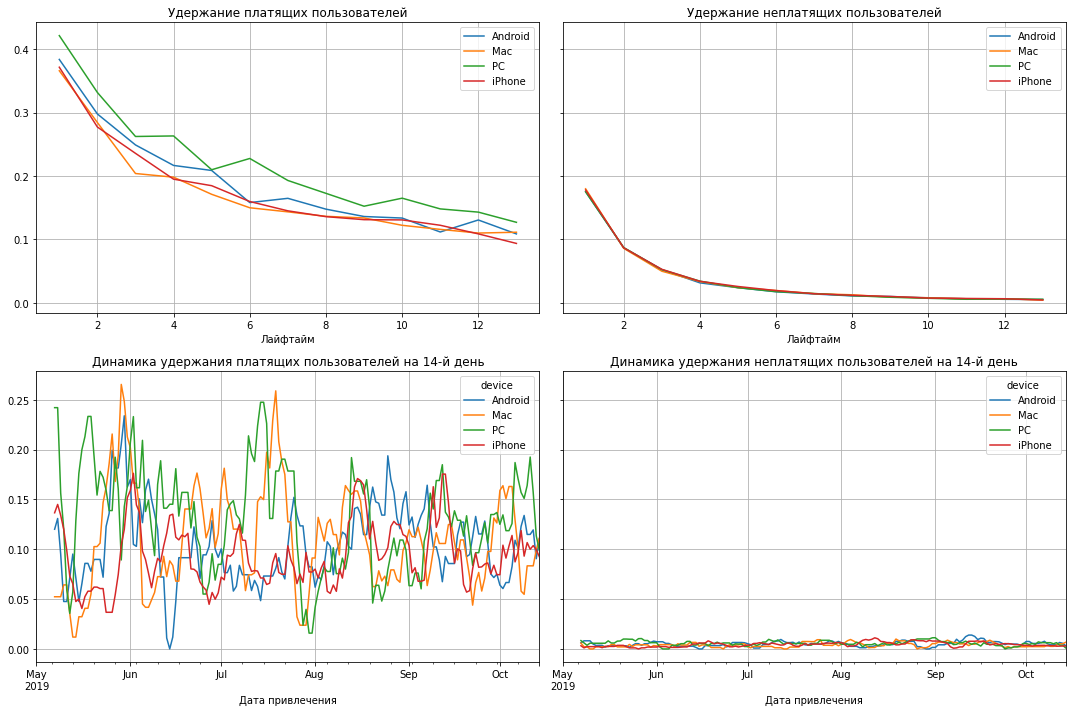

In [75]:
# Строим графики удержания
plot_retention(retention, retention_history, analysis_horizon, window=7)

По графикам удержания с разбивкой по устройствам можно сделать выводы:  
- Удержание по всем устройствам очень близкие,  а лучшие значения по `PC`.   
- Динамика удержания среди источников стабильна в течении всего времени все источники близки между собой.      
- Удержание и динамика удержания неплатящих пользователей имеют меньшие значения по сравнению с платящими, что нормально.

#### 6.7 Удержание по странам

In [76]:
# Рассчитываем удержание с разбивкой по странам
retentio_raw, retention, retention_history = get_retention(
    profiles_n_o, visits, observation_date, analysis_horizon, dimensions=['region']
)

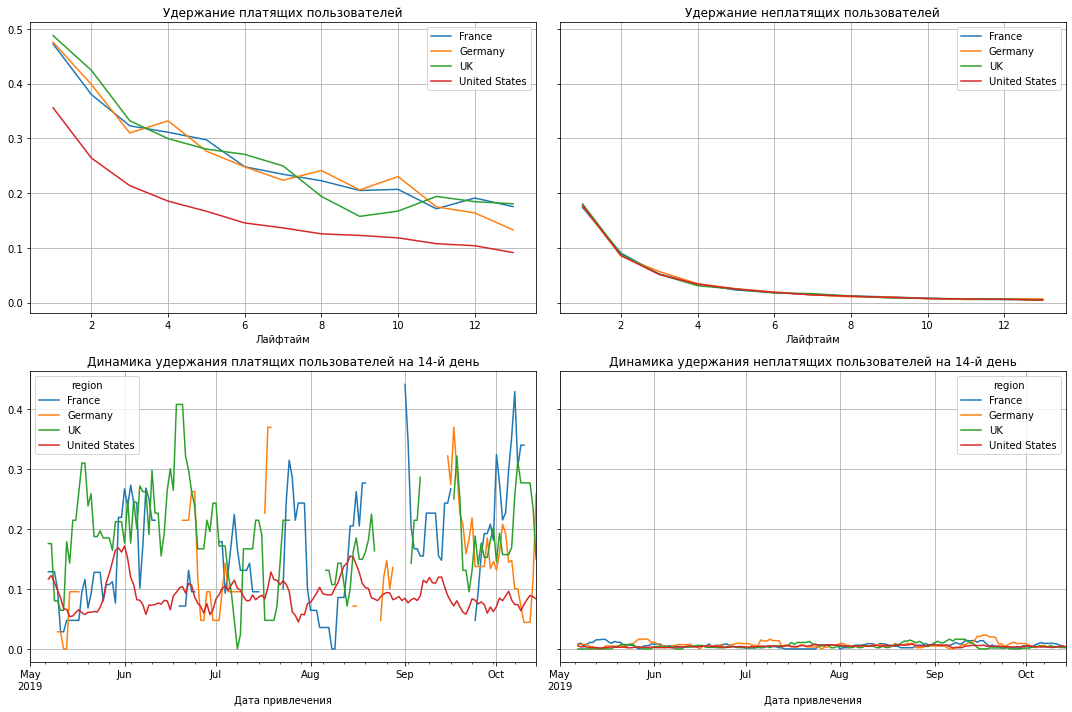

In [77]:
# Строим графики удержания
plot_retention(retention, retention_history, analysis_horizon, window=7)

По графикам удержания с разбивкой по странам можно сделать выводы:  
- Удержание по `United States` самое низкое, по остальным странам значения близкие.   
- Динамика удержания среди старн стабильна в течении всего времени, самы низкие значения у `United States`.      
- Удержание и динамика удержания неплатящих пользователей имеют меньшие значения по сравнению с платящими, что нормально.

#### 6.8 LTV, CAC и ROI по устройствам

In [78]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

In [79]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_n_o, orders, observation_date, analysis_horizon, dimensions
)

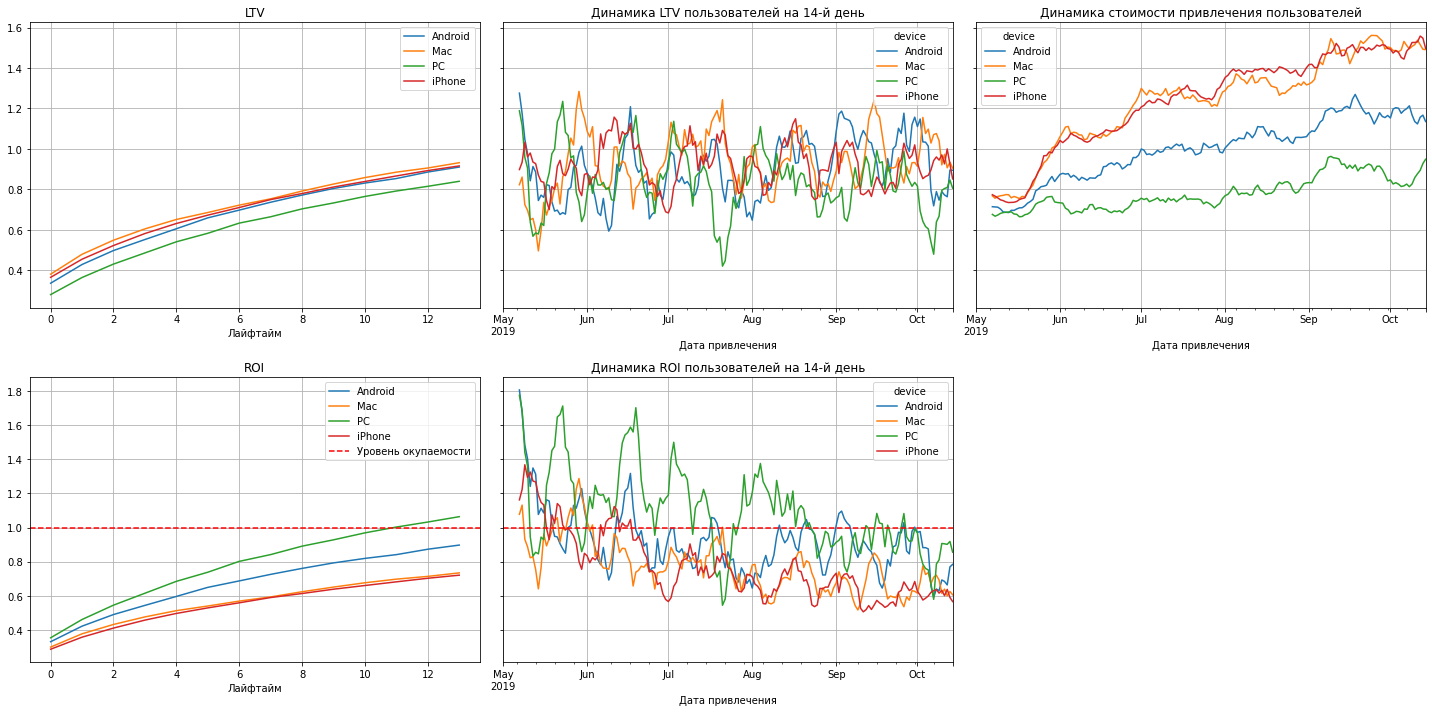

In [80]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

По графикам `LTV`, `CAC` и `ROI` с разбивкой по устройствам можно сделать выводы:  
- Окупаются только реклама по пользователям с устройствами `PC`.
- Не окупается реклама по пользователям с `Android`, `Mac` и `iPhone`.
- Начиная с июня расходы на привлечение пользвателей с `Android`, `Mac` и `iPhone` выросли и сильнее всего на пользователей с `Mac` и `iPhone`.  
- LTV изменяется вокруг средних значений и стабилен во времени.    

#### 6.9 LTV, CAC и ROI по странам

In [81]:
# Задаем разбивку по странам
dimensions = ['region']

In [82]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_n_o, orders, observation_date, analysis_horizon, dimensions
)

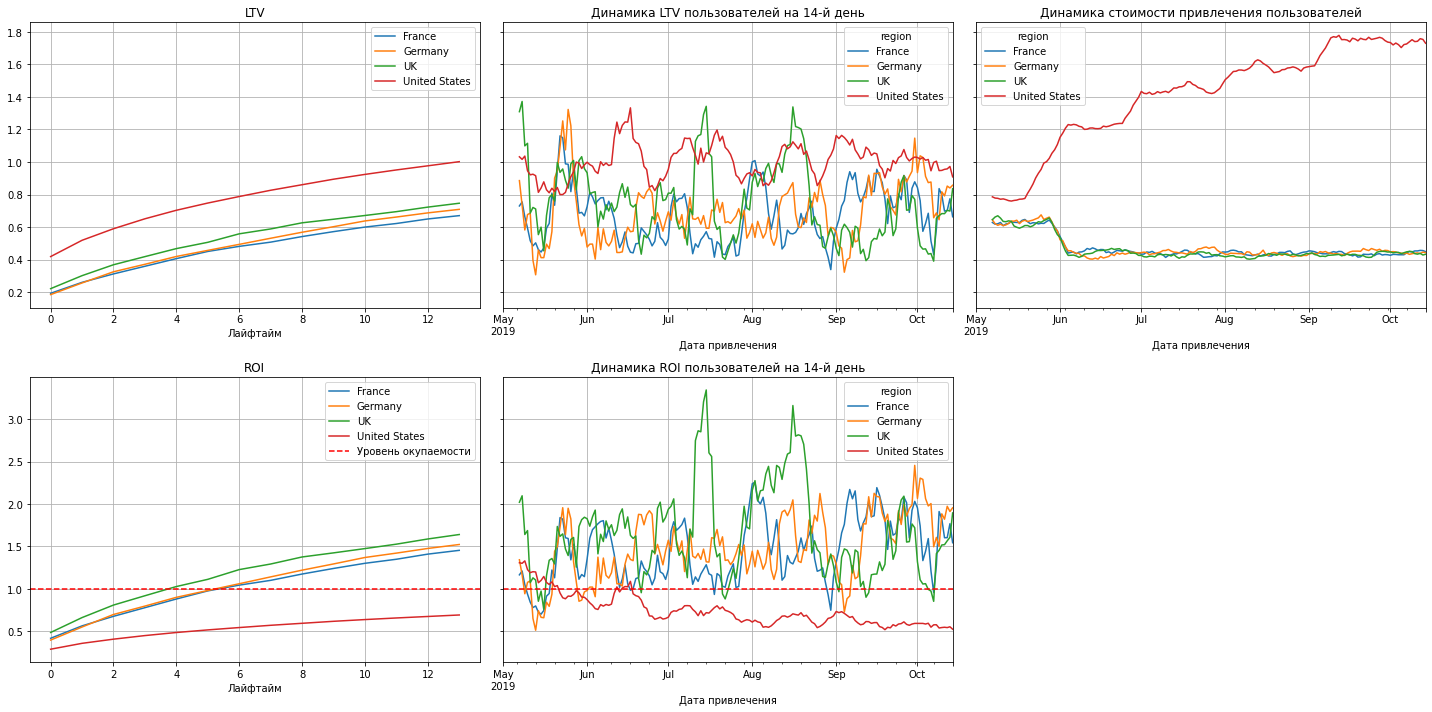

In [83]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

По графикам `LTV`, `CAC` и `ROI` с разбивкой по странам можно сделать выводы:  
- Окупаются реклама для всех стран кроме `United States`. Лучше всего окупается реклама для `UK`. 
- Начиная с июня расходы на привлечение пользоватей из `United States` выросли, а в остальных странах снизились.
- Начиная с июня возврат на инвестиции `ROI` пользователей из `United States` снизился, а по остальным странам `ROI` не претерпел сильных изменений.
- LTV изменяется вокруг средних значений и стабилен во времени.  

#### 6.10 LTV, CAC и ROI по рекламным каналам

In [84]:
# Задаем разбивку по устройствам

dimensions = ['channel']

In [85]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_n_o, orders, observation_date, analysis_horizon, dimensions
)

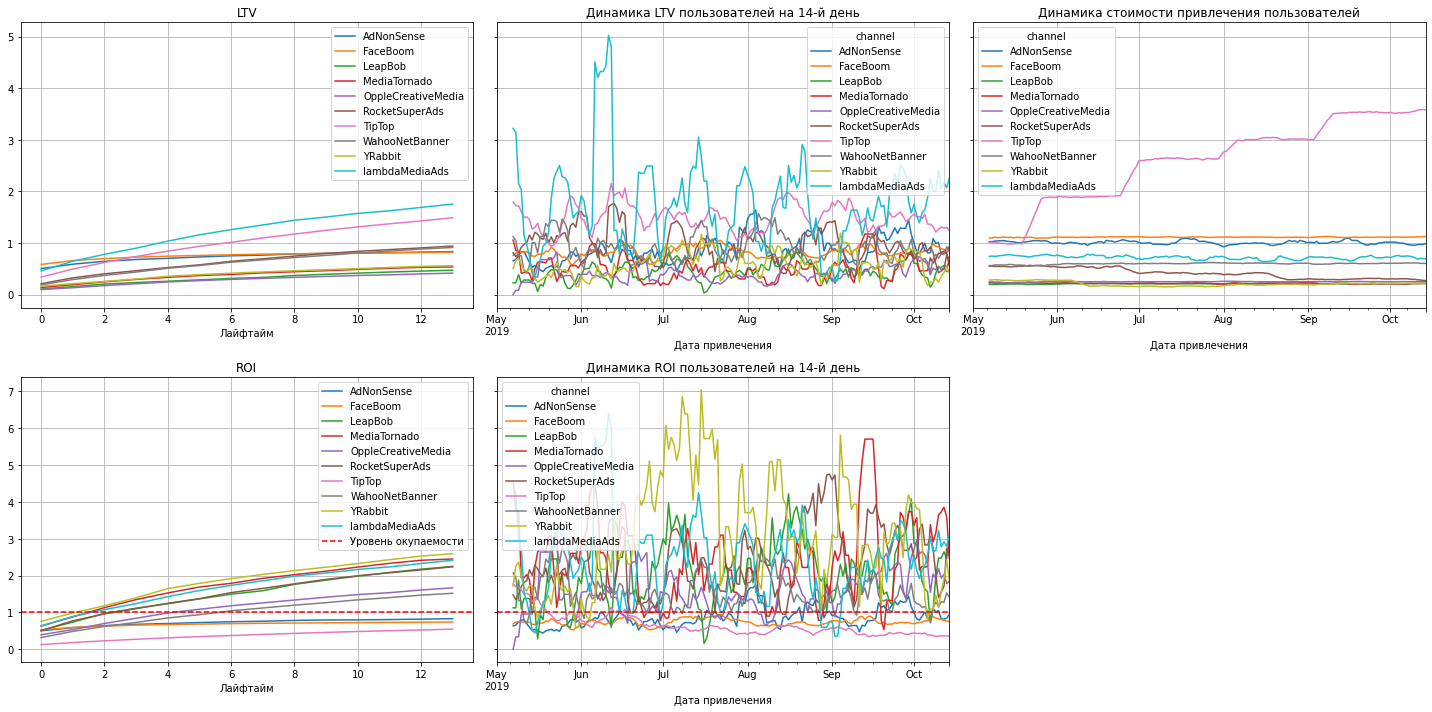

In [86]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

По графикам `LTV`, `CAC` и `ROI` с разбивкой по источникам можно сделать выводы:
- Окупается реклама для всех источников кроме `TipTop`, `FaceBoom`, `AdNonSense`. Лучще всего окупается для `YRabbit`, `MediaTornado` и `lambdaMediaAds`.  
- Начиная с июня расходы на привлечение пользоватей через `TipTop` растут с каждым месяцем.
- Начиная с июня возврат на инвестиции `ROI` для источника `TipTop` снижается. 
- LTV изменяется вокруг средних значений и стабилен во времени.  

#### 6.11 LTV, CAC и ROI по устройствам (без страны `United States`)

Дополнительно проанализируем окупаемость по устройствам, которые не в `United States`

In [87]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

In [88]:
# исключаем страну United States
profiles_n_o_noUSA = profiles_n_o.query('region!="United States"')

In [89]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_n_o_noUSA, orders, observation_date, analysis_horizon, dimensions
)

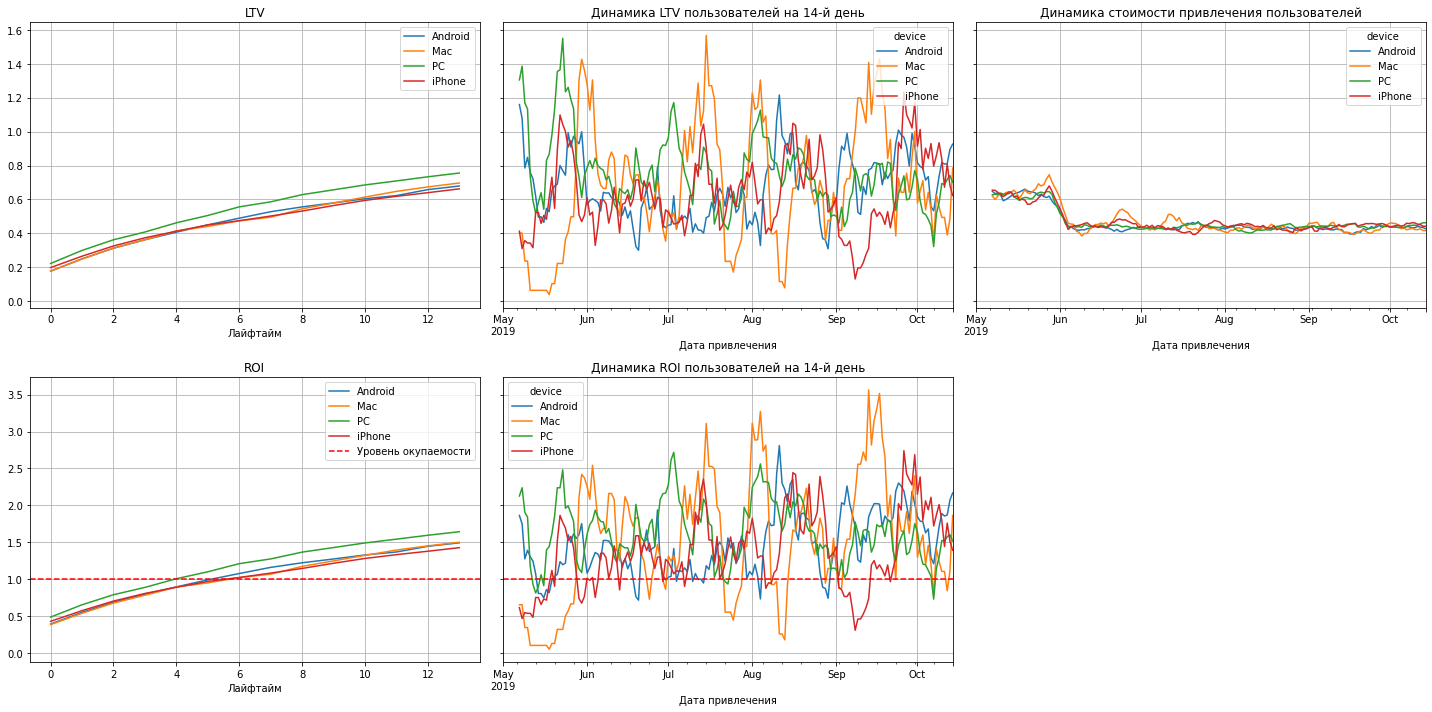

In [90]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

Итак, если исключить страну `United States`, то окупаются реклама по всем устройствам. Это говорит, что нет свзязи окупаемости и устройств пользователей.

#### 6.12 LTV, CAC и ROI по каналам (без страны `United States`)

Дополнительно проанализируем окупаемость по каналам, которые не в `United States`

In [91]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

In [92]:
# исключаем страну United States
profiles_n_o_noUSA = profiles_n_o.query('region!="United States"')

In [93]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_n_o_noUSA, orders, observation_date, analysis_horizon, dimensions
)

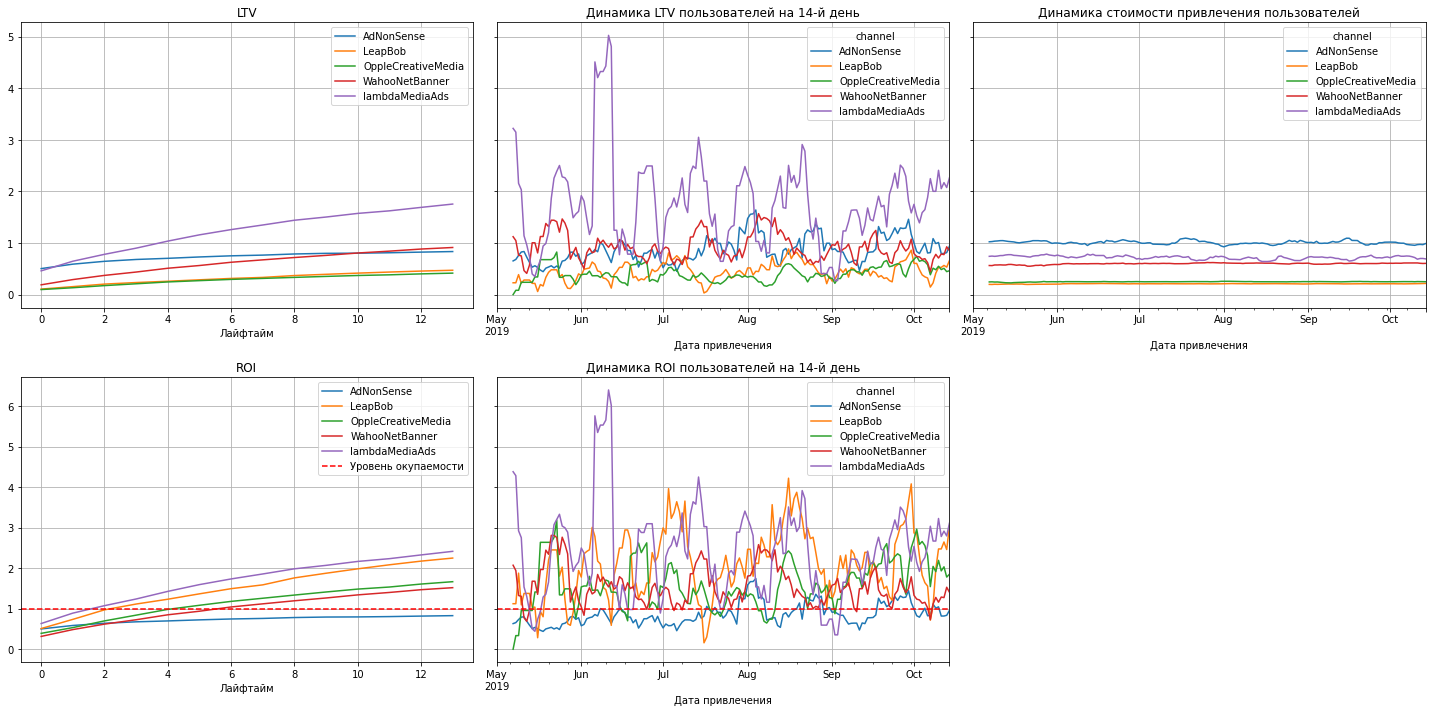

In [94]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

По графикам мы видим, что если исключить страну `United States`, то количество источников уменьшается. Пропадают два самых крупных источника привлечения `TipTop`, `FaceBoom`. Это говорит, что они работают только в `United States`.
Здесь мы видим, что лучше окупаются `lambdaMediaAds'

#### 6.13 LTV, CAC и ROI по каналам (только в `United States`)

Дополнительно проанализируем окупаемость по каналам, которые не в `United States`

In [95]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

In [96]:
# исключаем страну United States
profiles_n_o_noUSA = profiles_n_o.query('region=="United States"')

In [97]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_n_o_noUSA, orders, observation_date, analysis_horizon, dimensions
)

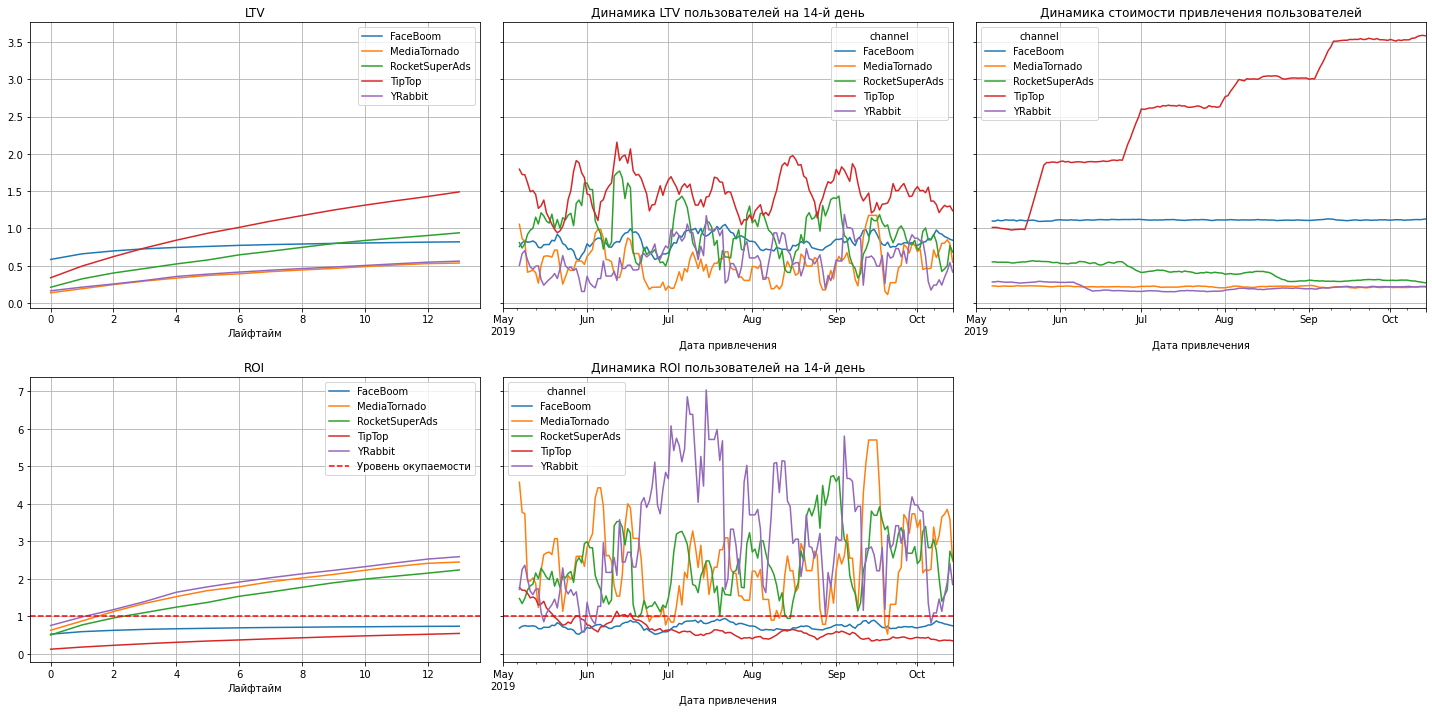

In [98]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

По графикам мы видим, что в `United States` не окупаются два самых крупных источника привлечения `TipTop`, `FaceBoom`.

#### 6.14 LTV, CAC и ROI по устройствам (только в `United States`)

Дополнительно проанализируем окупаемость по каналам, которые не в `United States`

In [99]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

In [100]:
# исключаем страну United States
profiles_n_o_noUSA = profiles_n_o.query('region=="United States"')

In [101]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_n_o_noUSA, orders, observation_date, analysis_horizon, dimensions
)

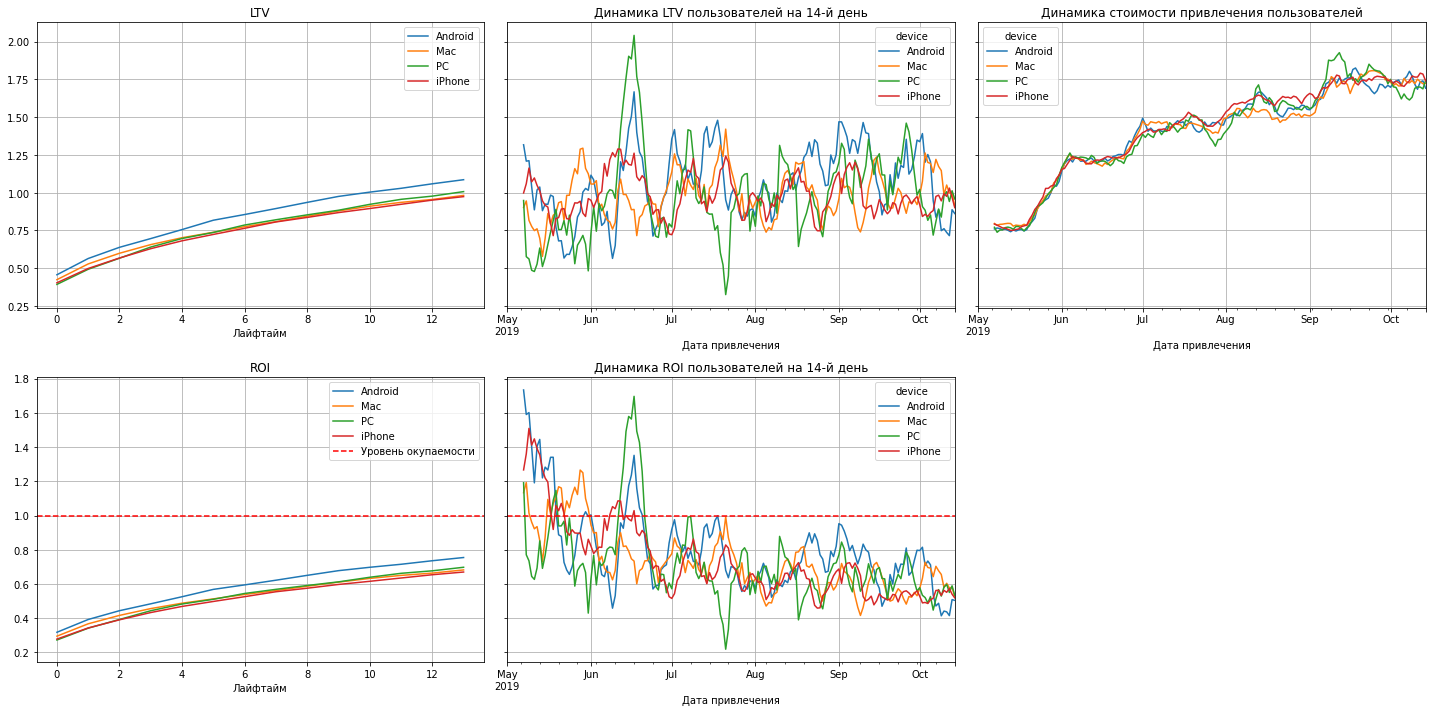

In [102]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

Итак:
- Реклама, направленная на привлечение пользователей в целом не окупается.
- Конверсия основных источников привлечения `TipTop` и `FaceBoom` входит в **ТОП-4** среди всех источников. Еще в **ТОП-4** входят  `lambdaMediaAds` и `AdNonSense`.
- Лучше всего конверсия у `Mac`.
- Конверсия по странам одинаковая.
- Удержание `FaceBoom`, который является одним из самых крупных источников привлечения в **3-4 раза** ниже чем по большей части источников.
- Стоимость привлечения в `TipTop` значительно выше остальных каналов.
- Не окупается реклама по пользователям с `Android`, `Mac` и `iPhone`, по каналам `TipTop`, `FaceBoom`, `AdNonSense` и для пользователей из `United States`.
- Лучше всего окупается реклама в `UK` для `PC` по  `YRabbit`, `MediaTornado`, `lambdaMediaAds`.
- В `United States` окупаются каналы привлечения `YRabbit`, `MediaTornado`, а по устройствам окупаемых нет, но ближе всего к окупаемости `Android`.
- Из-за значительного объема пользователей в США они оказывают значительное влияние на окупаемость рекламы в целом.
- наибольший отрицательный вклад в окупаемость вносят источники `TipTop`, `FaceBoom` в `United States`, реклама в которых не окупается.

## 7 Выводы

Целью было разобраться в причинах убыточности развлекательного приложения `Procrastinate Pro+`, в последние несколько месяцев, несмотря на огромные вложения в рекламу.
    
Входные данные(данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года):
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.  

Мы скорректировали названия столбцов в таблицах, исправили некорректный формат столбцов с датой в таблицах и устранили `0,11%` явных дубликатов в таблице `orders`.

Проанализировав маркетинговые данные мы имеем, что
- Всего на привлечение пользователей было потрачено **105497**.
- Больше **80%** расходов приходится на два канала `TipTop` и `FaceBoom`, а на `TipTop` прходится более **50%**.
- Каналы `TipTop` и `FaceBoom` привлекли **45%** всех пользователей.
- Самая высокая стоимость привлечения в канале `TipTop`.  
- Стоимость привлечения через TipTop более чем в **2 раза выше** чем в канале FaceBoom, где привлекли больше всего пользователей.

Проанализировав окупаемость рекламы мы имеем, что 
- Реклама, направленная на привлечение пользователей в целом не окупается.
- Конверсия всех источников похожа, в **ТОП-4** входят два самых крупных источника привлечения `TipTop` и `FaceBoom`.
- Удержание `FaceBoom`, который является одним из самых крупных источников привлечения, в **3-4 раза ниже** чем по большей части источников.
- Стоимость привлечения в `TipTop` значительно выше остальных каналов растет ежемесячно с июня.
- Не окупается реклама по пользователям с `Android`, `Mac` и `iPhone`, по каналам `TipTop`, `FaceBoom`, `AdNonSense` и для пользователей из `United States`.
- из-за значительного объема пользователей в США они оказывают значительное влияние на окупаемость рекламы в целом.
- наибольший отрицательный вклад в окупаемость вносят источники `TipTop`, `FaceBoom` в `United States`, реклама в которых не окупается.

В итоге мы имеет, что значительное влияние на убыточность приложения `Procrastinate Pro+` оказывают затраты на рекламу  через каналы `TipTop`, `FaceBoom` по причине низкого удержания в `FaceBoom` и высокой стоимости привлечения в `TipTop`.  

Причинами описанных выше проблем могут быть:
- низкое качество привлеченных пользоватлей в `FaceBoom` в `United States`.
- рост тарифов на привлечение в `TipTop` в `United States`.

Для того, чтобы повысить прибыльность приложения `Procrastinate Pro+` можно сделать следующее:
- Проверить и скорректировать рекламные компании в `FaceBoom` для повышения удержания пользователей.
- Провести переговоры с `TipTop` для снижения стомости привлечения пользователей.

В случае, если по каким-то из предложенных вариантов не удасться достичь результатов, то необходимо снизить количество привлекаемых пользователей через каналы `TipTop`, `FaceBoom` и перераспределить рекламный бюджет на 
- каналы привлеченя `YRabbit`, `MediaTornado`.
- страну `UK`.
- устройства `PC`.